In [1]:
from utils import wandb_to_xarray
from constants import WANDB_PROJECT, ERA5_DATA_RUN_WANDB_ID, ERA5_BEST_INFERENCE_WANDB_RUN_IDS
import cftime
from datetime import timedelta
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
variables = [
    "surface_pressure_due_to_dry_air",
    "total_water_path_budget_residual",
    "tendency_of_total_water_path_due_to_advection",
]
metrics = [f"inference/mean/weighted_mean_gen/{var}" for var in variables]
multiply_factors = {
    "surface_pressure_due_to_dry_air": 1,
    "total_water_path_budget_residual": 86400,
    "tendency_of_total_water_path_due_to_advection": 86400,
}
units = {
    "surface_pressure_due_to_dry_air": "Pa",
    "total_water_path_budget_residual": "mm/day",
    "tendency_of_total_water_path_due_to_advection": "mm/day",
}
long_names = {
    "surface_pressure_due_to_dry_air": "$< p_s^{dry} >$",
    "total_water_path_budget_residual": "$< \partial{TWP}/\partial{t} |_{res} >$",
    "tendency_of_total_water_path_due_to_advection": "Tendency of total water path due to advection",
}
truth_run_init_time = cftime.DatetimeProlepticGregorian(1940, 1, 1, 12)
prog_run_init_time = cftime.DatetimeProlepticGregorian(2001, 1, 1)

In [3]:
def get_dataset(run_id, metrics, multiply_factors, units, long_names, n_steps, init_time):
    ds = wandb_to_xarray(WANDB_PROJECT, run_id, metrics, n_steps)
    rename = {m: m.split('/')[-1] for m in metrics}
    ds = ds.rename(rename)
    absolute_time = [init_time + timedelta(days=day) for day in ds.lead_time.values]
    ds["lead_time"] = absolute_time
    ds = ds.rename({"lead_time": "time"})
    for var in variables:
        ds[var] *= multiply_factors[var]
        ds[var].attrs["units"] = units[var]
        ds[var].attrs["long_name"] = long_names[var]
    return ds

In [4]:
ds = get_dataset(
    ERA5_DATA_RUN_WANDB_ID,
    metrics,
    multiply_factors,
    units,
    long_names,
    50000,
    truth_run_init_time,
)

In [5]:
ds_prog = get_dataset(
    ERA5_BEST_INFERENCE_WANDB_RUN_IDS["10yr"],
    metrics,
    multiply_factors,
    units,
    long_names,
    14600,
    prog_run_init_time,
)

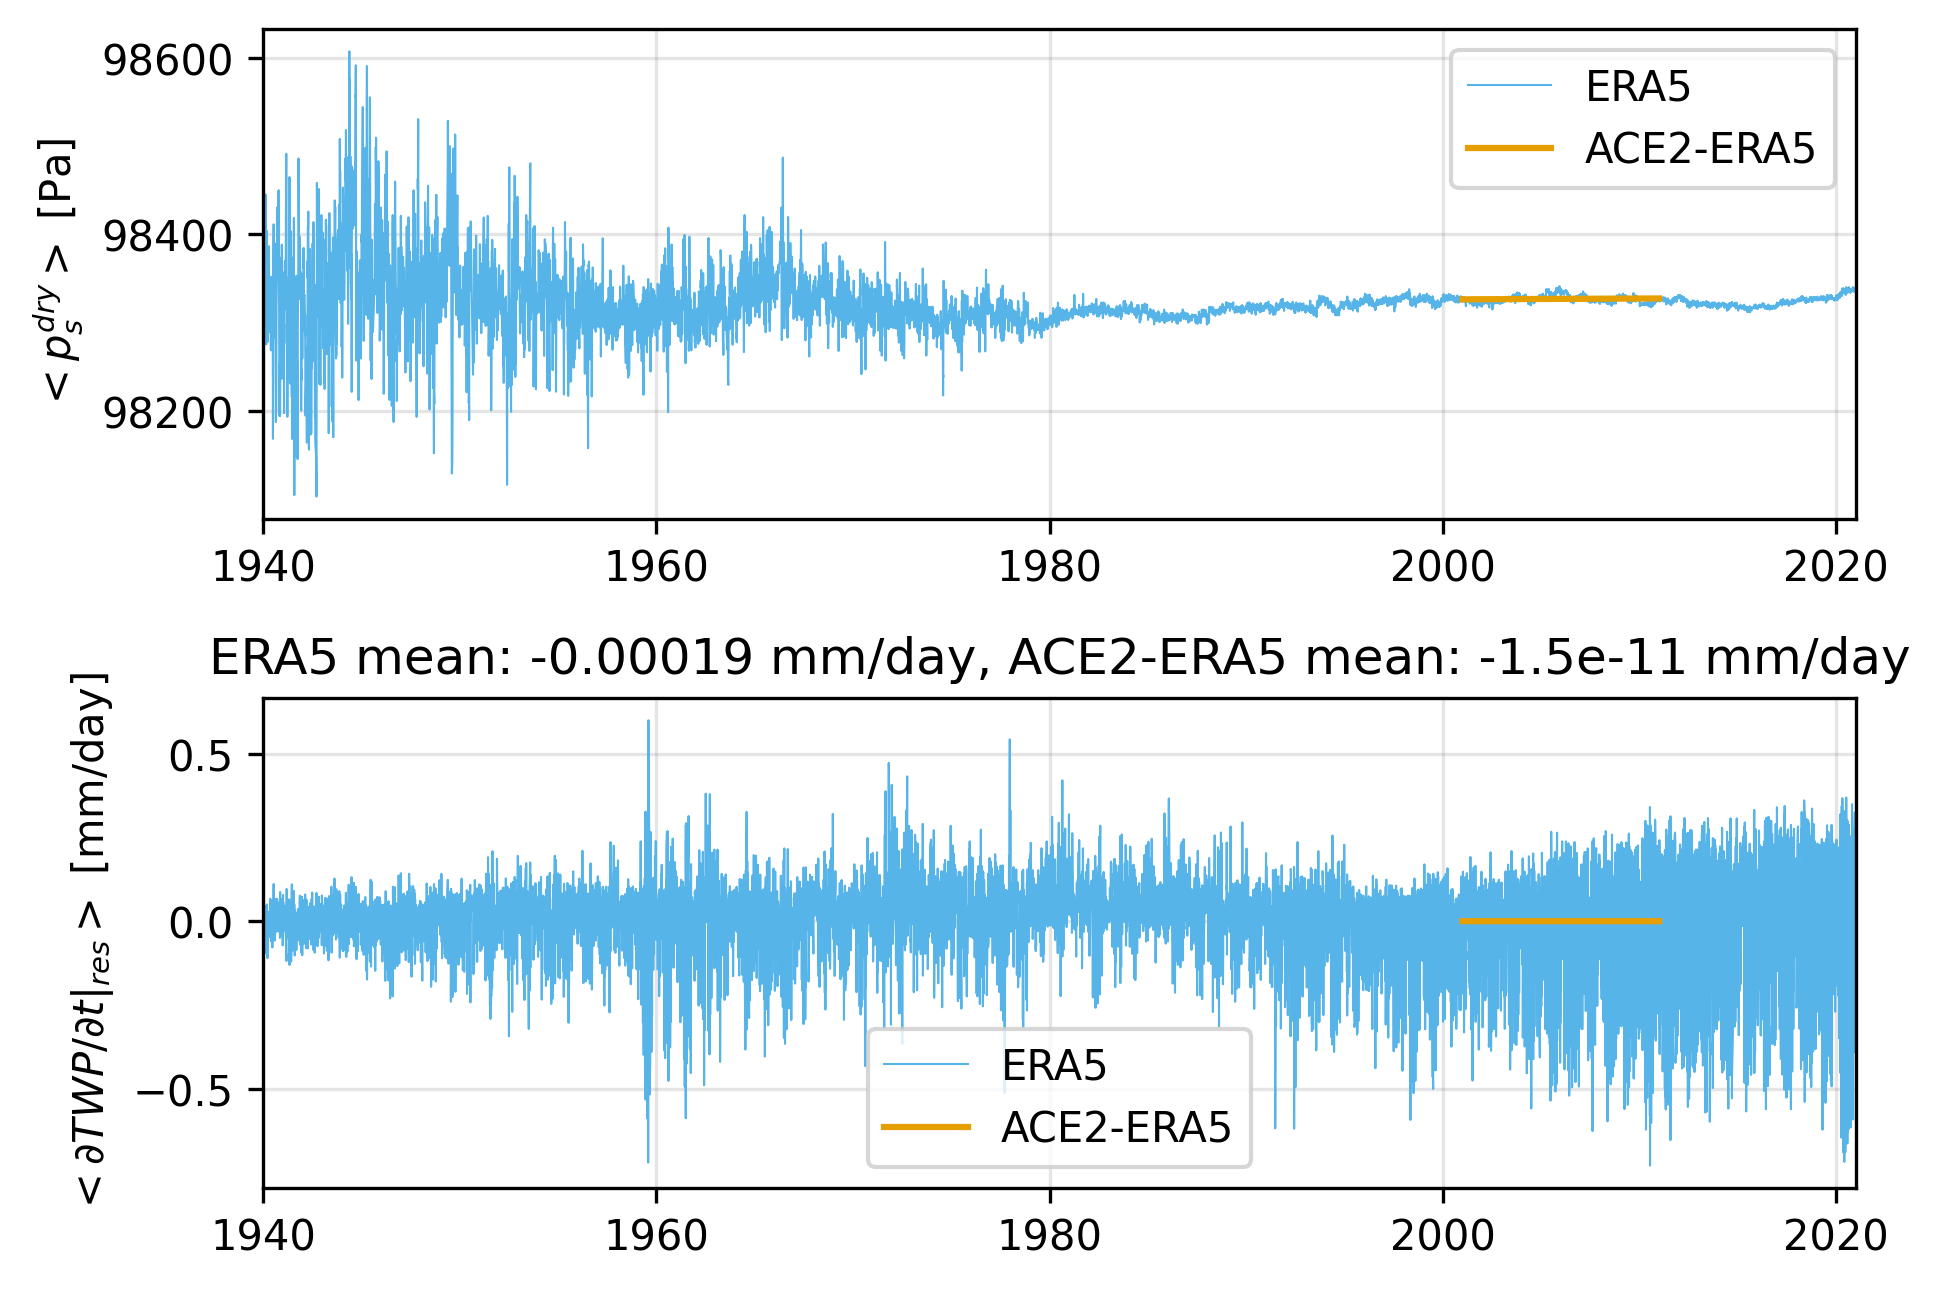

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(6.5, 4.4))
for i, var in enumerate(["surface_pressure_due_to_dry_air", "total_water_path_budget_residual"]):
    mean_value = ds[var].mean(dim="time").values.item()
    mean_value_ace = ds_prog[var].mean(dim="time").values.item()
    ds[var].plot(ax=axes[i], linewidth=0.5, label='ERA5')
    ds_prog[var].plot(ax=axes[i], label='ACE2-ERA5')
    axes[i].set_xlabel('')
    axes[i].set_xlim(cftime.DatetimeProlepticGregorian(1940, 1, 1), ds.time.values[-1])
    axes[i].legend()
    axes[i].grid(alpha=0.2, color='gray')
    if i == 1:
        # set title equal to the mean value
        axes[i].set_title(f"ERA5 mean: {mean_value:.2g} mm/day, ACE2-ERA5 mean: {mean_value_ace:.2g} mm/day")
fig.tight_layout()
fig.savefig("figures/era5_ace2_constraint_comparison.png", dpi=300, transparent=True)